### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [6]:
models_results = {
    'model': [],
    'F1': [],
    'ROC': []
}

In [7]:
def results(y_true, preds, name_model):
    precision, recall, thresholds = precision_recall_curve(y_true, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                                            fscore[ix],
                                                                                            precision[ix],
                                                                                            recall[ix],
                                                                                            roc_auc_score(y_true, preds)))
    models_results['model'].append(name_model)
    models_results['F1'].append(fscore[ix])
    models_results['ROC'].append(roc_auc_score(y_true, preds))

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Логистическая регрессия

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaller', MinMaxScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [11]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [13]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [14]:
results(y_test, preds, 'LogisticRegression')

Best Threshold=0.286079, F-Score=0.509, Precision=0.460, Recall=0.570, Roc_auc=0.771


### Случайный лес

In [15]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
            ])
    final_transformers.append((cont_col, cont_transformer))

In [16]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [17]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [19]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [20]:
results(y_test, preds, 'RandomForest')

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629, Roc_auc=0.864


### Градиентный бустинг

In [21]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
            ])
    final_transformers.append((cont_col, cont_transformer))

In [22]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [23]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [24]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [25]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [26]:
results(y_test, preds, 'GradientBoosting')

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, Roc_auc=0.876


### Оценки

In [27]:
models_results

{'model': ['LogisticRegression', 'RandomForest', 'GradientBoosting'],
 'F1': [0.5087719298245615, 0.6406406406406405, 0.6461211477151967],
 'ROC': [0.7712229591116805, 0.8635016710758334, 0.8757458662211781]}

Ожидаемо, что бустинг, как самая сложная модель, показывает и высокий результат. Проведем подбор гиперпараметров.

### Экономические оценки

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


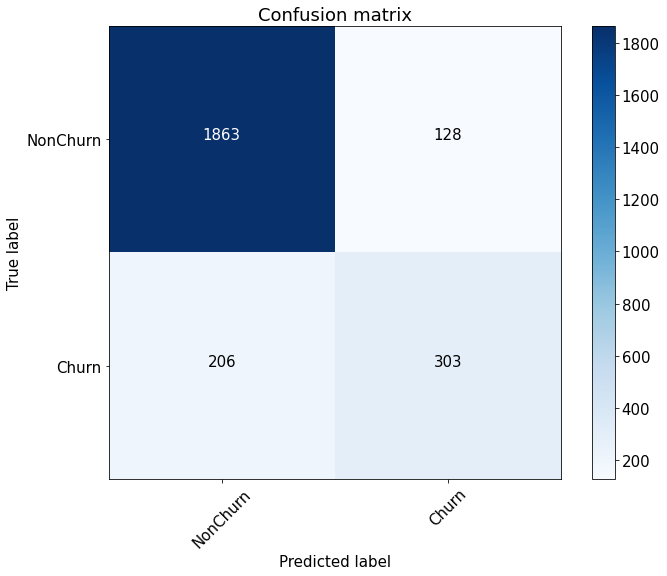

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Если ничего не делать, то у нас останется 1863+128=1991 пользователь и уйдет 206+303=509 пользователей. То есть мы заработаем на пользователях 1991*2=3982. Если мы, используя модель, будем звонить всем, кто предсказан как уходящий, их в данном случае 303+128=431, то потратим 431 доллар, при этом оставим только 303 человека, потому что 128 и не собирались уходить, и потеряем 206 человек, которые собирались уходить, а мы им не позвонили. Тогда у нас останется 1863+303+128=2294 клиента, с которых мы получим 4588 доллара, а потратили мы 431 доллар, то есть чистая прибыль 4157. В сравнении со случаем, когда мы не используем модель, мы увеличиваем прибыль на 175 долларов.

### Подбор гиперпараметров

In [29]:
params={'classifier__n_estimators':[100, 1000],
        'classifier__learning_rate':[0.01, 0.1],
        'classifier__min_samples_leaf':[1, 10]
        }

In [30]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__min_samples_leaf': 10,
 'classifier__n_estimators': 100}

In [31]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state = 42, learning_rate=0.1, min_samples_leaf=1, n_estimators=100)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [32]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [33]:
results(y_test, preds, 'GradienBoosting2.0')

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, Roc_auc=0.876


### Оценки

In [97]:
pd.DataFrame(models_results)

,model,F1,ROC
0,LogisticRegression,0.508772,0.771223
1,RandomForest,0.640641,0.863502
2,GradientBoosting,0.646121,0.875746
3,GradienBoosting2.0,0.646121,0.875746


Подбор гиперпараметров показал, что параметры по умолчанию для градиентного бустинга являются наиболее оптимальными при решении данной задачи, оценки совпадают, проводить повторные оценки экономической эффективности не требуется.